In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/household_power_consumption.txt', sep=';', parse_dates=[['Date', 'Time']],
                   date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%Y %H:%M:%S'))

# Rename columns for better understanding
data.rename(columns={
    'Global_active_power': 'Active_Power',
    'Global_reactive_power': 'Reactive_Power',
    'Global_intensity': 'Intensity',
    'Sub_metering_1': 'Sub_Metering_1',
    'Sub_metering_2': 'Sub_Metering_2',
    'Sub_metering_3': 'Sub_Metering_3'
}, inplace=True)

# Handle missing values by forward filling
data.fillna(method='ffill', inplace=True)

# Check the dataset structure
print(data.head())

# Convert to a time series format (Indexing by 'Timestamp')
data.set_index('Date_Time', inplace=True)


In [ ]:
# Convert 'Active_Power' column to numeric, coercing errors to NaN
data['Active_Power'] = pd.to_numeric(data['Active_Power'], errors='coerce')

# Handle missing values (e.g., forward fill)
data['Active_Power'].fillna(method='ffill', inplace=True)

# Check for NaN values and handle them (you could also choose to drop them)
data.dropna(subset=['Active_Power'], inplace=True)

In [ ]:
# Convert columns to numeric, coercing errors to NaN
columns_to_convert = ['Reactive_Power', 'Voltage', 'Intensity', 'Sub_Metering_1', 'Sub_Metering_2']

for column in columns_to_convert:
    data[column] = pd.to_numeric(data[column], errors='coerce')

# Check for NaN values and handle them (e.g., forward fill)
data.fillna(method='ffill', inplace=True)  # You can also use .bfill() or replace with a constant value

# Confirm the changes
print(data.dtypes)

In [ ]:
data.info()

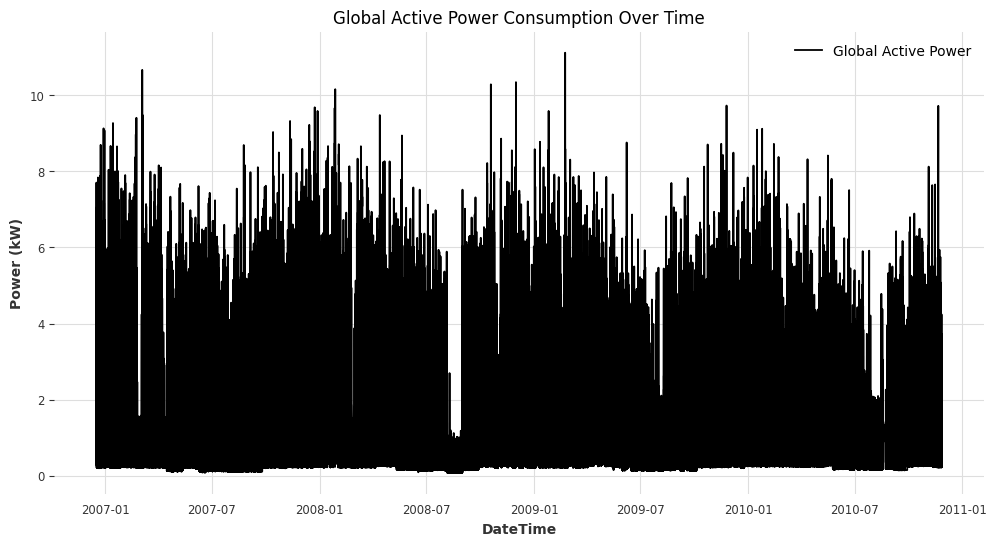

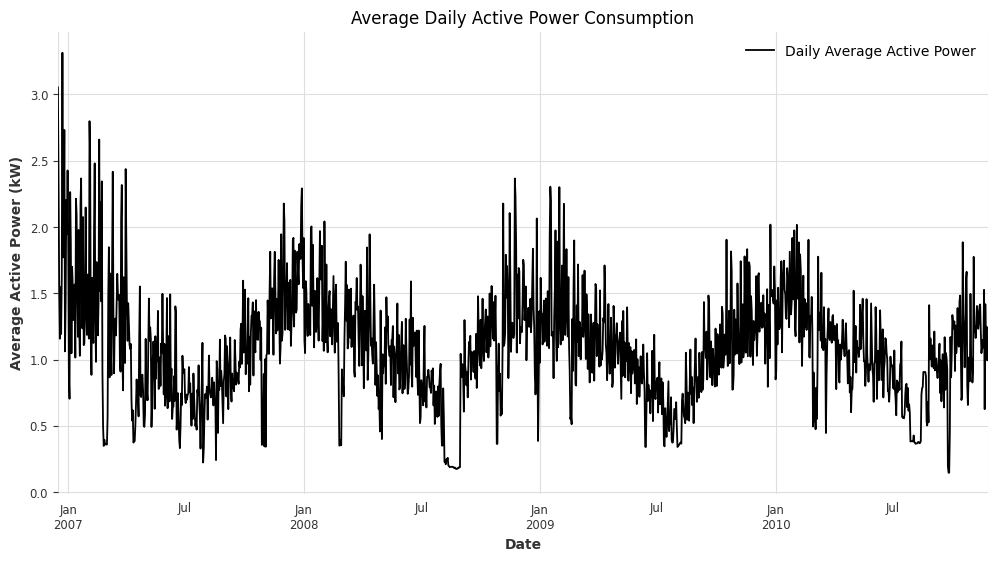

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# # Ensure 'Active_Power' is numeric and handle errors
# data['Active_Power'] = pd.to_numeric(data['Active_Power'], errors='coerce')

# # Check for NaN values and handle them (e.g., forward fill, drop, or replace)
# data['Active_Power'].fillna(method='ffill', inplace=True)  # Forward fill missing values
# # Alternatively, you could drop NaN values: data.dropna(subset=['Active_Power'], inplace=True)

# Plot Global Active Power over time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Active_Power'], label='Global Active Power')
plt.xlabel('DateTime')
plt.ylabel('Power (kW)')
plt.title('Global Active Power Consumption Over Time')
plt.legend()
plt.show()

# Explore daily patterns (Resampling to daily data)
daily_data = data.resample('D').mean()

# Plot daily consumption
plt.figure(figsize=(12, 6))
daily_data['Active_Power'].plot(label='Daily Average Active Power')
plt.title('Average Daily Active Power Consumption')
plt.xlabel('Date')
plt.ylabel('Average Active Power (kW)')
plt.legend()
plt.show()


In [ ]:
!pip install darts

In [44]:
from darts.models import TransformerModel

In [45]:
from darts.models import TCNModel

In [46]:
from darts.models import BlockRNNModel

In [ ]:
data.columns

In [48]:
data.head()

,Active_Power,Reactive_Power,Voltage,Intensity,Sub_Metering_1,Sub_Metering_2,Sub_Metering_3
Date_Time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [49]:

from darts import TimeSeries
from darts.metrics import mape
import matplotlib.pyplot as plt

In [ ]:
# Install Darts if not installed (uncomment the line if it's not installed)
# !pip install darts

# LSTM Model
lstm_model = BlockRNNModel(input_chunk_length=24, output_chunk_length=12, model="LSTM", n_epochs=2)

# Convert data to a TimeSeries object
ts = TimeSeries.from_dataframe(data, value_cols='Active_Power')

# Train a Time Series model (LSTM as an example)
train, val = ts.split_before(0.8)

lstm_model.fit(train)

# Predict and calculate residuals
forecast = lstm_model.predict(len(val))

In [ ]:
# Save the trained model to a specific file path (e.g., in your Google Drive or local directory)
model_save_path = "/content/drive/MyDrive/lstm_model.pth"  # Add a filename here
lstm_model.save(model_save_path)

# Print confirmation
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/lstm_model.pth


In [50]:
# Load the saved TCN model from the specified path
lstm_model = BlockRNNModel.load("/content/drive/MyDrive/lstm_model.pth")

In [ ]:
# Convert data to a TimeSeries object
ts = TimeSeries.from_dataframe(data, value_cols='Active_Power')

# Train a Time Series model (LSTM as an example)
train, val = ts.split_before(0.8)
# Predict and calculate residuals
forecast = lstm_model.predict(len(val))

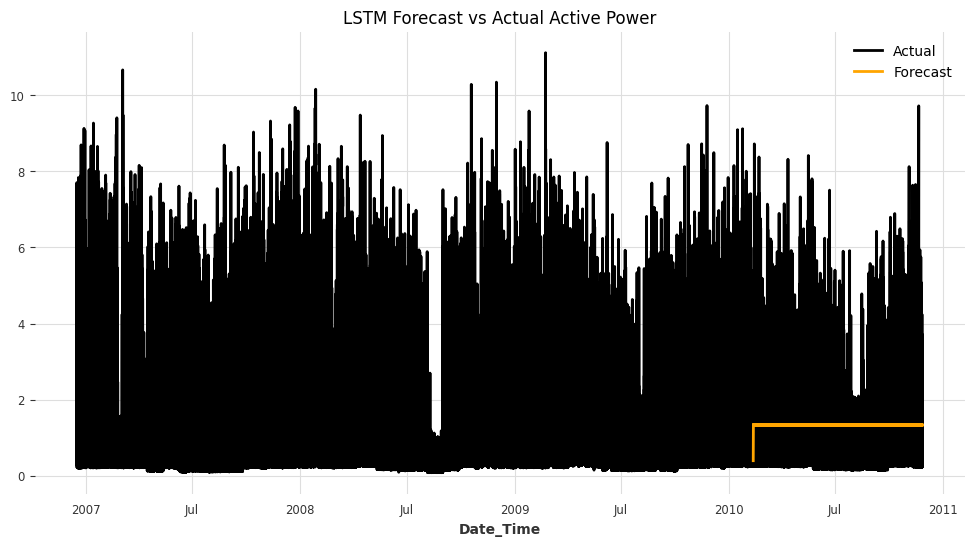

Anomalies Detected: 20753


In [ ]:
# Calculate prediction residuals (Anomalies detection based on residuals)
residuals = abs(forecast.values() - val.values())

# Flatten residuals to 1D array for further processing
residuals_flat = residuals.flatten()

# Convert residuals to Pandas Series to use .quantile() method
residuals_series = pd.Series(residuals_flat)

# Plot forecast vs actual values
plt.figure(figsize=(12, 6))
ts.plot(label='Actual')
forecast.plot(label='Forecast', color='orange')
plt.title('LSTM Forecast vs Actual Active Power')
plt.legend()
plt.show()

# Thresholding residuals to define anomalies (using the 95th percentile as the threshold)
threshold = residuals_series.quantile(0.95)  # Use .quantile() on the Pandas Series
anomalies = residuals_series > threshold
print("Anomalies Detected:", anomalies.sum())

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Check if forecast time index and actual time index align
print("Forecast Time Index:", forecast.time_index[:5])  # Print first 5 forecast time indices
print("Actual Time Index:", ts.time_index[:5])  # Print first 5 actual time indices

# Align forecast time index with the actual time index by slicing the forecast data
# Let's match the forecast time index to the range of the actual data (from 2006-12-16 to 2010-11-26)
forecast_start_date = ts.time_index[0]  # Start of actual data time range
forecast_end_date = ts.time_index[-1]  # End of actual data time range

# Slice the forecast to match the actual time range using .slice()
forecast_aligned = forecast.slice(forecast_start_date, forecast_end_date)

# Calculate prediction residuals (Anomalies detection based on residuals)
residuals = abs(forecast_aligned.values() - val.values())

# Flatten residuals to 1D array for further processing
residuals_flat = residuals.flatten()

# Convert residuals to Pandas Series to use .quantile() method
residuals_series = pd.Series(residuals_flat)

# Plot forecast vs actual values using Plotly
fig = go.Figure()

# Actual values (access time_index directly as an attribute)
fig.add_trace(go.Scatter(x=ts.time_index, y=ts.values(), mode='lines', name='Actual'))

# Forecast values (access time_index directly as an attribute)
fig.add_trace(go.Scatter(x=forecast_aligned.time_index, y=forecast_aligned.values(), mode='lines', name='Forecast', line=dict(color='orange')))

# Add title and labels
fig.update_layout(
    title='LSTM Forecast vs Actual Active Power',
    xaxis_title='DateTime',
    yaxis_title='Active Power (kW)',
    template='plotly_dark',  # You can change the template for style
)

# Show the plot
fig.show()

# Thresholding residuals to define anomalies (using the 95th percentile as the threshold)
threshold = residuals_series.quantile(0.95)  # Use .quantile() on the Pandas Series
anomalies = residuals_series > threshold
print("Anomalies Detected:", anomalies.sum())


In [52]:
from darts.metrics import rmse

## TCN MOdel

In [ ]:
# Train and evaluate multiple models
tcn_model = TCNModel(input_chunk_length=24, output_chunk_length=12,n_epochs=2)
tcn_model.fit(train)
tcn_forecast = tcn_model.predict(len(val))
print('TCN RMSE:', rmse(val, tcn_forecast))

In [ ]:
# Save the trained model to a specific file path (e.g., in your Google Drive or local directory)
model_save_path = "/content/drive/MyDrive/tcn_model.pth"  # Add a filename here
tcn_model.save(model_save_path)

# Print confirmation
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/tcn_model.pth


In [ ]:
# Load the saved TCN model from the specified path
tcn_model = TCNModel.load("/content/drive/MyDrive/tcn_model.pth")

# Now use the model to predict
tcn_forecast = tcn_model.predict(len(val))

In [ ]:
# Calculate prediction residuals (Anomalies detection based on residuals)
tcn_residuals = abs(tcn_forecast.values() - val.values())

# Flatten residuals to 1D array for further processing
tcn_residuals_flat = tcn_residuals.flatten()

# Convert residuals to Pandas Series to use .quantile() method
tcn_residuals_series = pd.Series(tcn_residuals_flat)

# Plot forecast vs actual values for TCN
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(x=ts.time_index, y=ts.values(), mode='lines', name='Actual'))

# Forecast values for TCN
fig.add_trace(go.Scatter(x=tcn_forecast.time_index, y=tcn_forecast.values(), mode='lines', name='Forecast', line=dict(color='orange')))

# Add title and labels
fig.update_layout(
    title='TCN Forecast vs Actual Active Power',
    xaxis_title='DateTime',
    yaxis_title='Active Power (kW)',
    template='plotly_dark',  # You can change the template for style
)

# Show the plot
fig.show()

# Thresholding residuals to define anomalies (using the 95th percentile as the threshold)
tcn_threshold = tcn_residuals_series.quantile(0.95)
tcn_anomalies = tcn_residuals_series > tcn_threshold
print("TCN Anomalies Detected:", tcn_anomalies.sum())


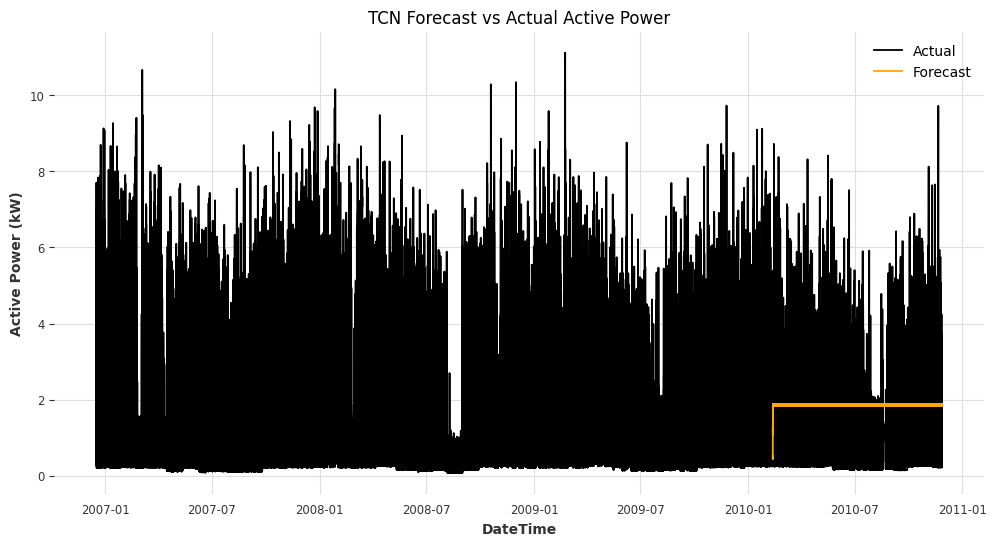

TCN Anomalies Detected: 20666


In [ ]:
# Flatten residuals to 1D array for further processing
tcn_residuals_flat = tcn_residuals.flatten()

# Convert residuals to Pandas Series to use .quantile() method
tcn_residuals_series = pd.Series(tcn_residuals_flat)

# Plot forecast vs actual values for TCN using Matplotlib
plt.figure(figsize=(12, 6))

# Actual values
plt.plot(ts.time_index, ts.values(), label='Actual')

# Forecast values for TCN
plt.plot(tcn_forecast.time_index, tcn_forecast.values(), label='Forecast', color='orange')

# Add title and labels
plt.title('TCN Forecast vs Actual Active Power')
plt.xlabel('DateTime')
plt.ylabel('Active Power (kW)')
plt.legend()

# Show the plot
plt.show()

# Thresholding residuals to define anomalies (using the 95th percentile as the threshold)
tcn_threshold = tcn_residuals_series.quantile(0.95)
tcn_anomalies = tcn_residuals_series > tcn_threshold
print("TCN Anomalies Detected:", tcn_anomalies.sum())


In [ ]:
from darts.metrics import rmse

## Transformer model

In [ ]:
transformer_model = TransformerModel(input_chunk_length=24, output_chunk_length=12,n_epochs=2)
transformer_model.fit(train)
transformer_forecast = transformer_model.predict(len(val))

In [55]:
print('Transformer RMSE:', rmse(val, transformer_forecast))

Transformer RMSE: 0.9175800366341668


In [56]:
# Save the trained model to a specific file path (e.g., in your Google Drive or local directory)
model_save_path = "/content/drive/MyDrive/transformer_model.pth"  # Add a filename here
transformer_model.save(model_save_path)

# Print confirmation
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/transformer_model.pth


In [ ]:
# Calculate prediction residuals (Anomalies detection based on residuals)
transformer_residuals = abs(transformer_forecast.values() - val.values())

# Flatten residuals to 1D array for further processing
transformer_residuals_flat = transformer_residuals.flatten()

# Convert residuals to Pandas Series to use .quantile() method
transformer_residuals_series = pd.Series(transformer_residuals_flat)

# Plot forecast vs actual values for Transformer
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(x=ts.time_index, y=ts.values(), mode='lines', name='Actual'))

# Forecast values for Transformer
fig.add_trace(go.Scatter(x=transformer_forecast.time_index, y=transformer_forecast.values(), mode='lines', name='Forecast', line=dict(color='orange')))

# Add title and labels
fig.update_layout(
    title='Transformer Forecast vs Actual Active Power',
    xaxis_title='DateTime',
    yaxis_title='Active Power (kW)',
    template='plotly_dark',  # You can change the template for style
)

# Show the plot
fig.show()

# Thresholding residuals to define anomalies (using the 95th percentile as the threshold)
transformer_threshold = transformer_residuals_series.quantile(0.95)
transformer_anomalies = transformer_residuals_series > transformer_threshold
print("Transformer Anomalies Detected:", transformer_anomalies.sum())


In [ ]:
# Predict and calculate residuals for Transformer
transformer_forecast = transformer_model.predict(len(val))
transformer_residuals = abs(transformer_forecast.values() - val.values())

# Flatten residuals to 1D array for further processing
transformer_residuals_flat = transformer_residuals.flatten()

# Convert residuals to Pandas Series to use .quantile() method
transformer_residuals_series = pd.Series(transformer_residuals_flat)

# Plot forecast vs actual values for Transformer using Matplotlib
plt.figure(figsize=(12, 6))

# Actual values
plt.plot(ts.time_index, ts.values(), label='Actual')

# Forecast values for Transformer
plt.plot(transformer_forecast.time_index, transformer_forecast.values(), label='Forecast', color='orange')

# Add title and labels
plt.title('Transformer Forecast vs Actual Active Power')
plt.xlabel('DateTime')
plt.ylabel('Active Power (kW)')
plt.legend()

# Show the plot
plt.show()

# Thresholding residuals to define anomalies (using the 95th percentile as the threshold)
transformer_threshold = transformer_residuals_series.quantile(0.95)
transformer_anomalies = transformer_residuals_series > transformer_threshold
print("Transformer Anomalies Detected:", transformer_anomalies.sum())


In [59]:
# Compare RMSE for models
lstm_rmse = rmse(val, forecast)
print('LSTM RMSE:', lstm_rmse)

# Evaluate based on other metrics like MAPE (Mean Absolute Percentage Error)
lstm_mape = mape(val, forecast)
print('LSTM MAPE:', lstm_mape)


LSTM RMSE: 0.942853656563403
LSTM MAPE: 190.05987603291507


In [ ]:
from darts.metrics import rmse, mape
import pandas as pd

# LSTM Model (already trained)
lstm_forecast = lstm_model.predict(len(val))

# Calculate RMSE for LSTM
lstm_rmse = rmse(val, lstm_forecast)
print('LSTM RMSE:', lstm_rmse)

# Calculate MAPE for LSTM
lstm_mape = mape(val, lstm_forecast)
print('LSTM MAPE:', lstm_mape)

# Calculate prediction residuals for LSTM
lstm_residuals = abs(lstm_forecast.values() - val.values())
lstm_residuals_flat = lstm_residuals.flatten()
lstm_residuals_series = pd.Series(lstm_residuals_flat)

# Thresholding residuals to define anomalies (95th percentile)
lstm_threshold = lstm_residuals_series.quantile(0.95)
lstm_anomalies = lstm_residuals_series > lstm_threshold
print("LSTM Anomalies Detected:", lstm_anomalies.sum())
print("Total Records in Validation:", len(val))

# TCN Model (already trained)
tcn_forecast = tcn_model.predict(len(val))

# Calculate RMSE for TCN
tcn_rmse = rmse(val, tcn_forecast)
print('TCN RMSE:', tcn_rmse)

# Calculate MAPE for TCN
tcn_mape = mape(val, tcn_forecast)
print('TCN MAPE:', tcn_mape)

# Calculate prediction residuals for TCN
tcn_residuals = abs(tcn_forecast.values() - val.values())
tcn_residuals_flat = tcn_residuals.flatten()
tcn_residuals_series = pd.Series(tcn_residuals_flat)

# Thresholding residuals to define anomalies (95th percentile)
tcn_threshold = tcn_residuals_series.quantile(0.95)
tcn_anomalies = tcn_residuals_series > tcn_threshold
print("TCN Anomalies Detected:", tcn_anomalies.sum())
print("Total Records in Validation:", len(val))

# Transformer Model (already trained)
transformer_forecast = transformer_model.predict(len(val))

# Calculate RMSE for Transformer
transformer_rmse = rmse(val, transformer_forecast)
print('Transformer RMSE:', transformer_rmse)

# Calculate MAPE for Transformer
transformer_mape = mape(val, transformer_forecast)
print('Transformer MAPE:', transformer_mape)

# Calculate prediction residuals for Transformer
transformer_residuals = abs(transformer_forecast.values() - val.values())
transformer_residuals_flat = transformer_residuals.flatten()
transformer_residuals_series = pd.Series(transformer_residuals_flat)

# Thresholding residuals to define anomalies (95th percentile)
transformer_threshold = transformer_residuals_series.quantile(0.95)
transformer_anomalies = transformer_residuals_series > transformer_threshold
print("Transformer Anomalies Detected:", transformer_anomalies.sum())
print("Total Records in Validation:", len(val))


In [61]:
def anomaly_alert_system(residuals, threshold):
    """Simple alert system based on residuals threshold"""
    anomalies = residuals > threshold
    if anomalies.any():
        print("ALERT: Anomalies detected in the energy consumption patterns!")
        print(f"Anomalous time steps: {anomalies[anomalies == True]}")
    else:
        print("No anomalies detected.")

# Trigger alert system for LSTM model residuals
anomaly_alert_system(residuals, threshold)


ALERT: Anomalies detected in the energy consumption patterns!
Anomalous time steps: [ True  True  True ...  True  True  True]


In [ ]:
import pandas as pd

def anomaly_alert_system(record, residuals_lstm, residuals_tcn, residuals_transformer, threshold_lstm, threshold_tcn, threshold_transformer):
    """Alert system that checks whether a specific record is an anomaly for each model"""
    # Calculate the residual for the record (assuming record index corresponds to the validation set index)
    record_residual_lstm = abs(record - residuals_lstm)
    record_residual_tcn = abs(record - residuals_tcn)
    record_residual_transformer = abs(record - residuals_transformer)
    # Anomaly detection for LSTM
    lstm_anomaly = record_residual_lstm > threshold_lstm
    if lstm_anomaly:
        print(f"ALERT: LSTM detected anomaly at record {record}!")
    else:
        print(f"LSTM: No anomaly at record {record}.")
    # Anomaly detection for TCN
    tcn_anomaly = record_residual_tcn > threshold_tcn
    if tcn_anomaly:
        print(f"ALERT: TCN detected anomaly at record {record}!")
    else:
        print(f"TCN: No anomaly at record {record}.")
    # Anomaly detection for Transformer
    transformer_anomaly = record_residual_transformer > threshold_transformer
    if transformer_anomaly:
        print(f"ALERT: Transformer detected anomaly at record {record}!")
    else:
        print(f"Transformer: No anomaly at record {record}.")

# Example usage:
record_index = 10  # Assume we're checking the 10th record (change as needed)

# Get the corresponding time index from val's index (DatetimeIndex)
time_index_for_record = val.time_index[record_index]

# Use the time index to slice the record from the TimeSeries
record = val.slice(time_index_for_record, time_index_for_record)

# Call the anomaly alert system with LSTM, TCN, Transformer residuals and thresholds
anomaly_alert_system(
    record,
    lstm_residuals[record_index],  # Get the residual for the record from LSTM model
    tcn_residuals[record_index],   # Get the residual for the record from TCN model
    transformer_residuals[record_index],  # Get the residual for the record from Transformer model
    lstm_threshold,  # Threshold for LSTM model
    tcn_threshold,   # Threshold for TCN model
    transformer_threshold  # Threshold for Transformer model
)
